In [71]:
import numpy as np
import pandas as pd
import mne

import matplotlib.pyplot as plt
import seaborn as sns

from swlda import SWLDA
from pyedflib import highlevel
from datetime import datetime
from mne.decoding import CSP

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
board = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"],
         ["I",    "J",  "H",   "L",    "M",    "N",     "O",    "P"],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"],
         ["6",    "7",  "8",   "9",    "0",    ".",     "RET",  "BS"],
         ["CTRL", "=",  "DEL", "HOME", "UPAW", "END",   "PGUP", "SHIFT"],
         ["SAVE", "'",  "F2",  "LFAW", "DNAW", "RTAW",  "PGON", "PAUSE"],
         ["CAPS", "F5", "TAB", "EC",   "ESC",  "EMAIL", "!",    "SLEEP"]]


def RCIndexConveter(board: list[list[int]], index: int) -> str:
    """
    Convert index on the board to the character.

    Parameters:
        - board (2d list of str): a rectangle board to display characters.
        - index: the index on each location

    Returns:
        the character corresponding to the given index.
    """
    num_cols = len(board[0])
    r = (index - 1) // num_cols
    c = (index - 1) %  num_cols
    return board[r][c]


def eventIDs_to_strings(board: list[list[int]], event_ids: np.array):
    """
    Convert a seq of event IDs to the corresponding seq of characters.

    Parameters:
        - board (2d list of str): a rectangle board to display characters.
        - event_ids (1d np.array of int): a seq of event IDs.
    """
    sequence = ''
    for id in event_ids:
        sequence += RCIndexConveter(board, id)
    return sequence

A notch filter is a type of band-stop filter, which attenuates frequencies within a specific range while passing all other frequencies unaltered. Here, we remove frequency at $60$ hz since this certain frequency is the grid frequency here at US, which will disturb our analysis later if we don't remove it.

In [19]:
filename = '../data/RC/Train/A01_SE001RC_Train01.edf'
# Read and load data.
raw_data = mne.io.read_raw_edf(filename, preload=True, verbose=False)
# Find indices of channels whose name starts with 'EEG'.
eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
# Notch freq=60 from raw_data in these EEG channels.
raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)

<RawEDF | A01_SE001RC_Train01.edf, 114 x 34984 (136.7 s), ~30.5 MB, data loaded>

In [27]:
current_target_events = mne.find_events(raw_data, stim_channel='CurrentTarget',
                                        verbose=False)
current_target = current_target_events[:,2] # 3rd column contains event ids
eventIDs_to_strings(board, current_target)

'DRIVING'

In [30]:
# Find stimulus events and target stimulus events.
# Non-zero value in `StimulusBegin` indicates stimulus onset.
stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                  verbose=False)
# Non-zero value in `StimulusType` if is target stimulus event.
targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                  verbose=False)

# Label target and non-target events.
# Note that the event_id is stored in the third column in events array.
targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
stim_events[targstim_indices,2]  = 1 # set event_id of target events as 1
stim_events[~targstim_indices,2] = 0 # set event_id of non-target events as 0

# Epoch data based on target and non-target epoch labels.
t_min,t_max = 0, 0.8 # feature extraction window
event_dict = {'target': 1, 'non_target': 0} # stimulus event label -> event_id
epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                    event_id=event_dict, preload=True, baseline=None,
                    proj=False, picks=eeg_channels)

Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


In [31]:
epochs.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG_F3, EEG_Fz, EEG_F4, EEG_T7, EEG_C3, EEG_Cz, EEG_C4, EEG_T8, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 30.0 Hz
 meas_date: 2020-01-01 00:00:00 UTC
 nchan: 32
 projs: []
 sfreq: 256.0 Hz
>

To start with, we pick the eight most significant channels and the corresponding epochs. The `core_epochs` is just a part of the overall epochs, but only contains information of the eight channels here.

In [36]:
core_channel_names = ('EEG_Fz',  'EEG_Cz',  'EEG_P3', 'EEG_Pz', 'EEG_P4',
                      'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
core_eeg_channels = mne.pick_channels(raw_data.info['ch_names'],
                                      core_channel_names)
core_epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                         event_id=event_dict, preload=True, baseline=None,
                         proj=False, picks=core_eeg_channels, verbose=False)

To get some intuition, we can average the EEG signals across targets' epochs and non-targets' epochs respectively. Then, we can plot these two time-series curves together to see if there are detectable (and hopefully obvious) differences betweent the two classes.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "mean"
combining channels using "mean"


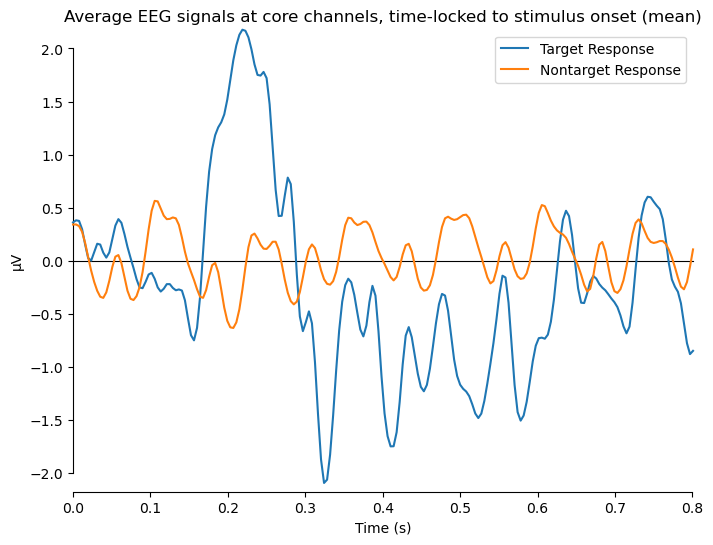

[<Figure size 800x600 with 1 Axes>]

In [33]:
# Average target and nontarget signals
erp_target = core_epochs['target'].average()
erp_nontarget = core_epochs['non_target'].average()
figure_title = 'Average EEG signals at core channels, time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             combine='mean',
                             show_sensors=False,
                             title=figure_title,
                             legend=1)

In [150]:
needed_num_timestamps = 195
small_sample_size = 15

In [151]:
train_file = '../data/RC/Train/A01_SE001RC_Train01.edf'
raw_train_data = mne.io.read_raw_edf(train_file, preload=True, verbose=False)
eeg_channels = mne.pick_channels_regexp(raw_train_data.info['ch_names'], 'EEG')
raw_train_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
train_epochs = utils.get_core_epochs(raw_train_data)

In [152]:
train_features, train_response = utils.split_data(train_epochs,
                                                  n_times=needed_num_timestamps,
                                                  n_samples=small_sample_size)

In [153]:
test_file = '../data/RC/Test/A01_SE001RC_Test07.edf'
raw_test_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)
eeg_channels = mne.pick_channels_regexp(raw_test_data.info['ch_names'], 'EEG')
raw_test_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
test_epochs = utils.get_core_epochs(raw_test_data)

In [154]:
test_features, test_response = utils.split_data(test_epochs,
                                                n_times=needed_num_timestamps,
                                                n_samples=small_sample_size)

In [155]:
clf = SWLDA(penter=0.1, premove=0.15)
clf.fit(train_features, train_response)

In [156]:
auc = clf.test(test_features, test_response)
auc

0.5731487748160489

In [157]:
# TODO: use train data to derive KDE pdf curve
scores = pd.DataFrame(clf.test(test_features), columns=['score'])

In [158]:
scores['is_target'] = test_response.astype('int')

<AxesSubplot: xlabel='score', ylabel='Density'>

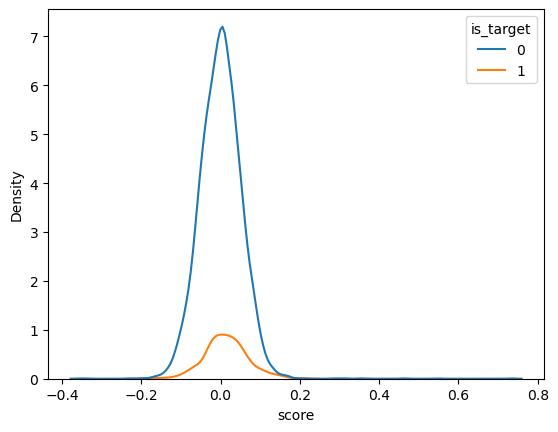

In [159]:
sns.kdeplot(data=scores, x='score', hue='is_target')

<AxesSubplot: xlabel='score', ylabel='Density'>

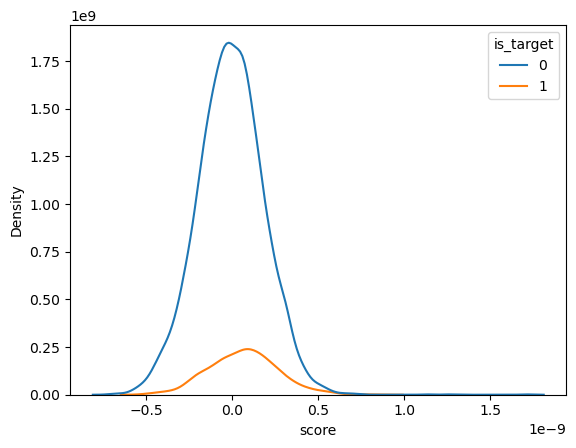

In [160]:
from sklearn.linear_model import LogisticRegression

lgt_clf = LogisticRegression()
lgt_clf.fit(X=train_features, y=train_response)
lgt_scores = np.dot(train_features, lgt_clf.coef_.T)
lgt_scores = pd.DataFrame(lgt_scores, columns=['score'])
lgt_scores['is_target'] = train_response.astype('int')
sns.kdeplot(data=lgt_scores, x='score', hue='is_target')

In [161]:
# te = [[[1,2,3,4],
#        [8,3,2,1]],
#       [[8,8,8,8],
#        [6,6,6,6]]]

# me = np.array(te)
# me.shape
# new = blockwise_average_3D(me, (1,1,2))
# new.reshape(-1, 2)